# Leios simulation analysis for late-release attacks

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

### Define utility functions

In [2]:
sort_factors <- function(fs, ascending=TRUE) {
    xs <- fs[as.numeric(sub(" .*$", "", fs)) %>% order]
    if (ascending)
        xs
    else
        rev(xs)
}

## Experiment: Varying delay in EB attack

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.R")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


         Adversary                     EB delay                Tx attack     
 33% adversary:552682   EB attack: 6.5 s/EB:140881   Tx attack: 100%:312326  
                        EB attack: 7.0 s/EB:138183   Tx attack: none:240356  
                        EB attack: 7.5 s/EB:135463                           
                        EB attack: none    :138155                           
                                                                             
                                                                             
                                                                             
      Tx size              Throughput      Tx start [s]  Tx stop [s] 
 1500 B/Tx:552682   0.150 TxMB/s:552682   Min.   :60    Min.   :660  
                                          1st Qu.:60    1st Qu.:660  
                                          Median :60    Median :660  
                                          Mean   :60    Mean   :660  
                          

In [4]:
label <- lifecycle[, unique(paste(`Tx size`, `Throughput`, `Adversary`, `Tx attack`, sep=", "))]
label

[1] "1500 B/Tx, 0.150 TxMB/s, 33% adversary, Tx attack: none"
[2] "1500 B/Tx, 0.150 TxMB/s, 33% adversary, Tx attack: 100%"

In [5]:
fixed <- c("Tx size", "Throughput", "Adversary", "Tx attack")

In [6]:
variedX <- c("EB delay")

In [7]:
variedY <- c("Tx attack")

In [8]:
varied <- c(variedY, variedX)

In [9]:
ebFactor <- function(x)
    factor(x, levels=paste("EB attack:", c("none", "6.5 s/EB", "7.0 s/EB", "7.5 s/EB")))

In [10]:
lifecycle[, `:=`(
    `VariedX`=factor(`Tx attack`),
    `VariedY`=ebFactor(`EB delay`)
)]

In [11]:
facet_varied <- function(scales="fixed", wide=FALSE) {
    if (wide)
        facet_grid(`VariedY` ~ `VariedX`, scales=scales)
    else
        facet_grid(`VariedX` ~ `VariedY`, scales=scales)
}

#### Range of transaction injection

In [12]:
txFirst <- lifecycle[, median(`Tx start [s]`)]
txLast <- lifecycle[, median(`Tx stop [s]`)]
txWindow <- txLast - txFirst
simFinish <- lifecycle[, median(`Sim stop [s]`)]

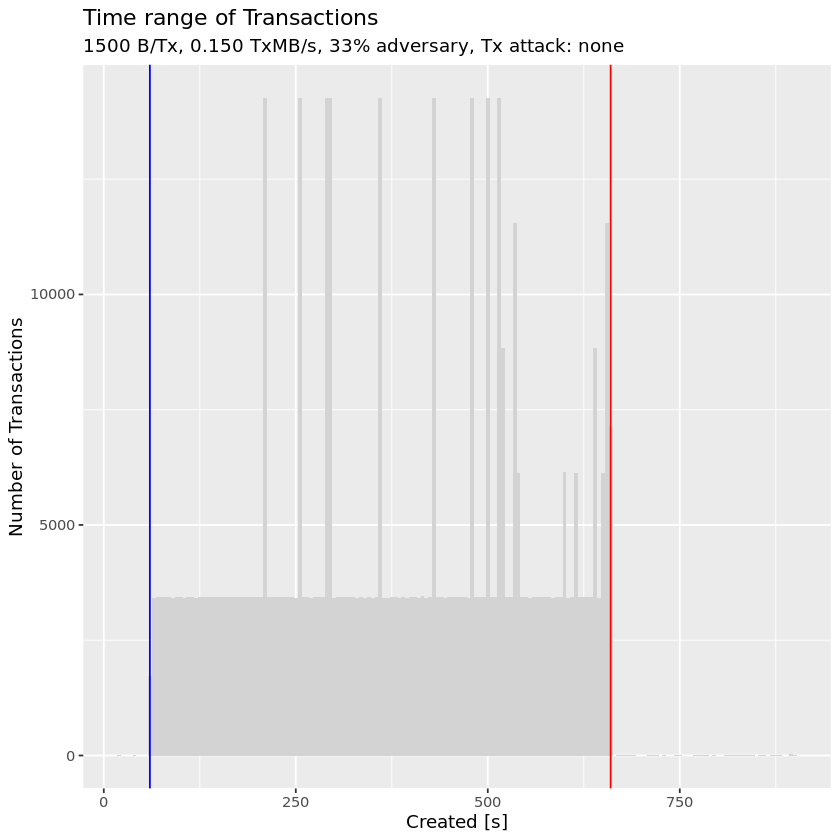

In [13]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions", label)

#### Actual TPS

In [14]:
dtmp <- lifecycle[
    `Message` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow
    ),
    c(fixed, varied)
]
setorderv(dtmp, varied)
dtmp

Tx size,Throughput,Adversary,Tx attack,Tx attack.1,EB delay,Demand [tx/s]
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: 100%,Tx attack: 100%,EB attack: 6.5 s/EB,134.4767
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: 100%,Tx attack: 100%,EB attack: 7.0 s/EB,129.9733
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: 100%,Tx attack: 100%,EB attack: 7.5 s/EB,125.4700
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: 100%,Tx attack: 100%,EB attack: none,129.9733
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: none,Tx attack: none,EB attack: 6.5 s/EB,100.0000
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: none,Tx attack: none,EB attack: 7.0 s/EB,100.0017
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: none,Tx attack: none,EB attack: 7.5 s/EB,100.0017
1500 B/Tx,0.150 TxMB/s,33% adversary,Tx attack: none,Tx attack: none,EB attack: none,100.0000


#### Size of persisted data

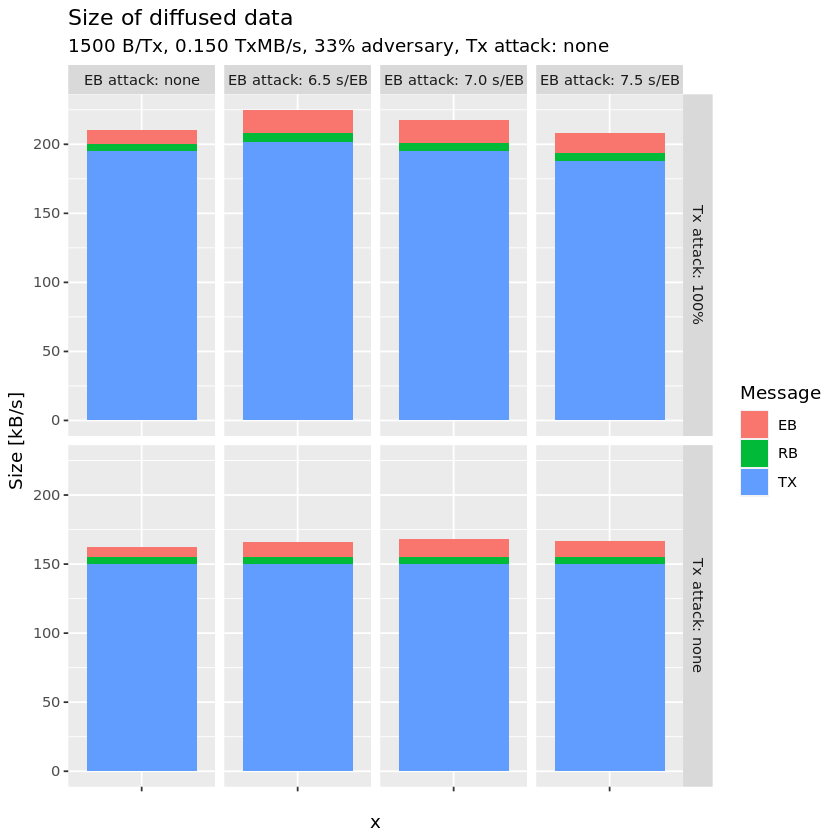

In [15]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        c("VariedX", "VariedY", "Message")
    ],
    aes(x="", y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_varied(scales="fixed") +
    ggtitle("Size of diffused data", subtitle=label)

In [16]:
ggsave("plots/sizes.png", units="in", dpi=150, width=16, height=8)

#### Spatial efficiency

In [17]:
dtmp <- lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        varied
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            varied
        ],
        on=varied
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), varied]
setorderv(dtmp, varied)
dtmp

Tx attack,EB delay,Space efficiency [%]
<fct>,<fct>,<dbl>
Tx attack: 100%,EB attack: 6.5 s/EB,89.68267
Tx attack: 100%,EB attack: 7.0 s/EB,89.60194
Tx attack: 100%,EB attack: 7.5 s/EB,90.44416
Tx attack: 100%,EB attack: none,92.57302
Tx attack: none,EB attack: 6.5 s/EB,90.42449
Tx attack: none,EB attack: 7.0 s/EB,89.32111
Tx attack: none,EB attack: 7.5 s/EB,89.91971
Tx attack: none,EB attack: none,92.39999


In [18]:
lifecycle[
            `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`VariedX`, `VariedY`)
        ]

VariedX,VariedY,Non-tx size [B]
<fct>,<fct>,<dbl>
Tx attack: none,EB attack: none,97404236
Tx attack: none,EB attack: 6.5 s/EB,99532220
Tx attack: 100%,EB attack: none,126360784
Tx attack: none,EB attack: 7.5 s/EB,100090956
Tx attack: 100%,EB attack: 7.5 s/EB,124853832
Tx attack: 100%,EB attack: 6.5 s/EB,134952488
Tx attack: none,EB attack: 7.0 s/EB,100761740
Tx attack: 100%,EB attack: 7.0 s/EB,130550752


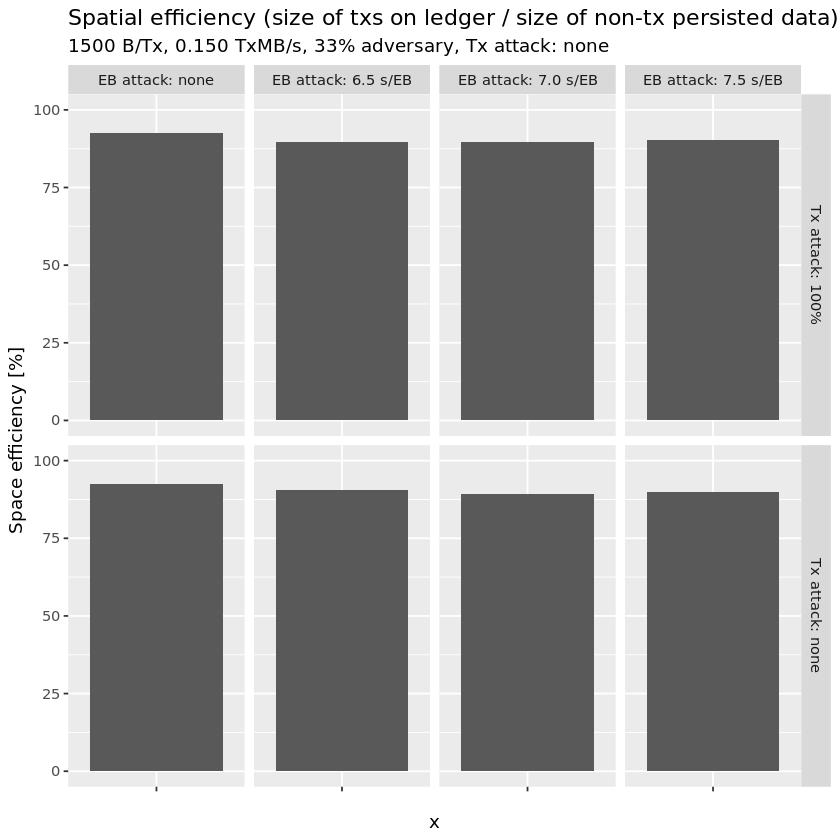

In [19]:
ggplot(
    lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`VariedX`, `VariedY`)
    ][
        lifecycle[
            `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            .(`VariedX`, `VariedY`)
        ],
        on=c("VariedX", "VariedY")
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), .(`VariedX`, `VariedY`)],
    aes(x="", y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_varied(scales="fixed") +
    ylim(0, 100) +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [20]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the EB

In [21]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Tx attack,EB delay,Time to reach EB [s]
<fct>,<fct>,<dbl>
Tx attack: 100%,EB attack: 6.5 s/EB,40.99847
Tx attack: 100%,EB attack: 7.0 s/EB,40.98572
Tx attack: 100%,EB attack: 7.5 s/EB,35.79256
Tx attack: 100%,EB attack: none,12.72751
Tx attack: none,EB attack: 6.5 s/EB,23.19994
Tx attack: none,EB attack: 7.0 s/EB,38.07282
Tx attack: none,EB attack: 7.5 s/EB,38.23435
Tx attack: none,EB attack: none,21.35558


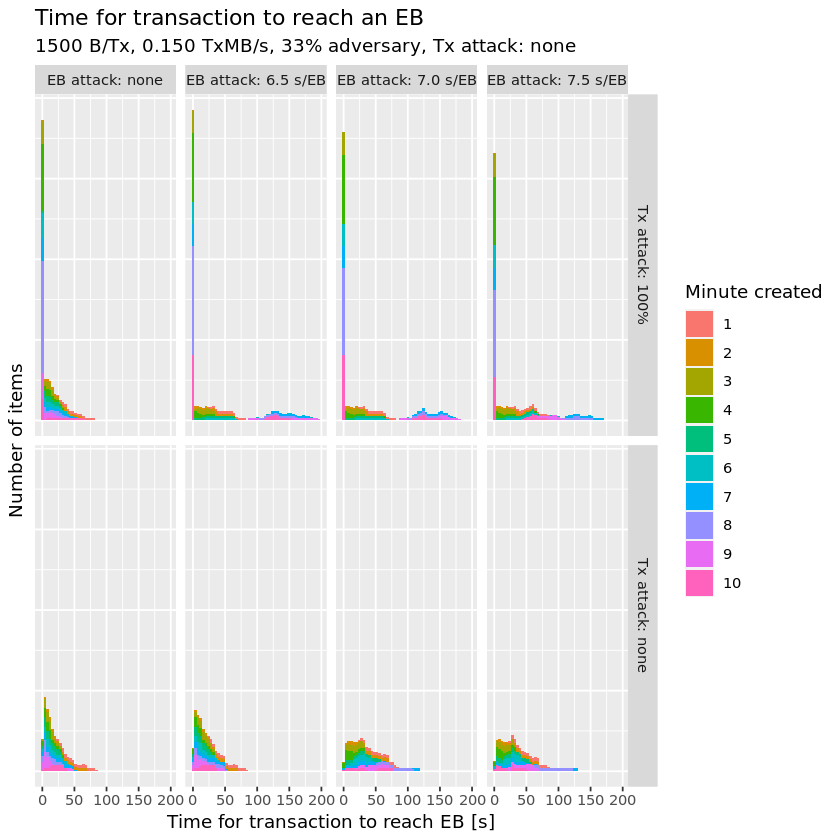

In [22]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_varied() +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the ledger

In [24]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Tx attack,EB delay,Time to reach ledger [s]
<fct>,<fct>,<dbl>
Tx attack: 100%,EB attack: 6.5 s/EB,144.87251
Tx attack: 100%,EB attack: 7.0 s/EB,136.46377
Tx attack: 100%,EB attack: 7.5 s/EB,125.32535
Tx attack: 100%,EB attack: none,40.35888
Tx attack: none,EB attack: 6.5 s/EB,62.86619
Tx attack: none,EB attack: 7.0 s/EB,91.62602
Tx attack: none,EB attack: 7.5 s/EB,88.64139
Tx attack: none,EB attack: none,48.40747


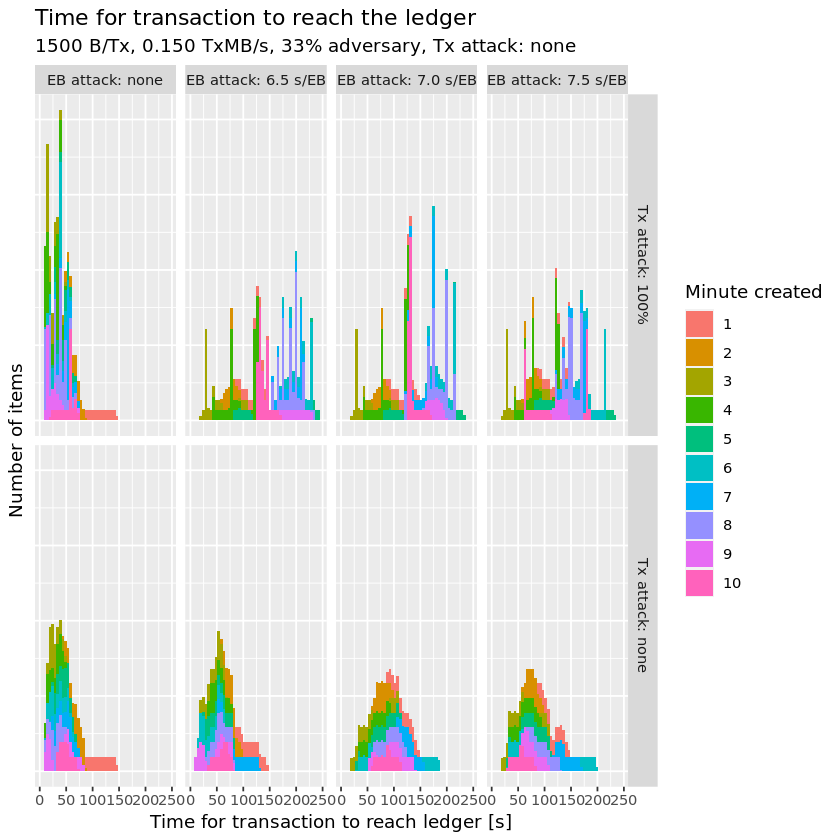

In [25]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_varied() +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [26]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

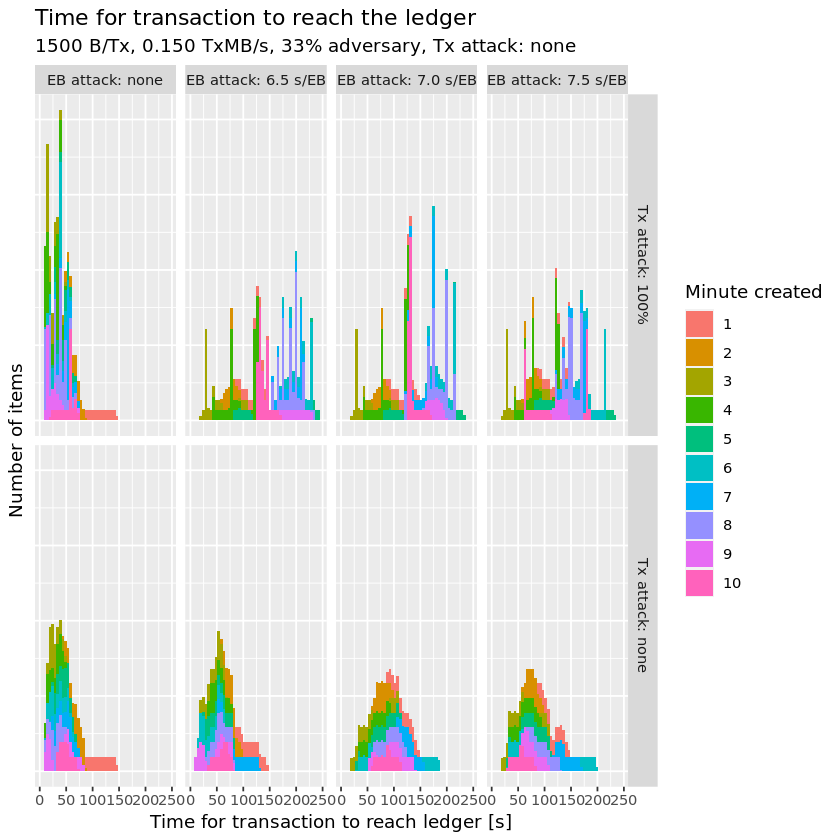

In [27]:
ggplot(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`VariedX`, `VariedY`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_varied() +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [28]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

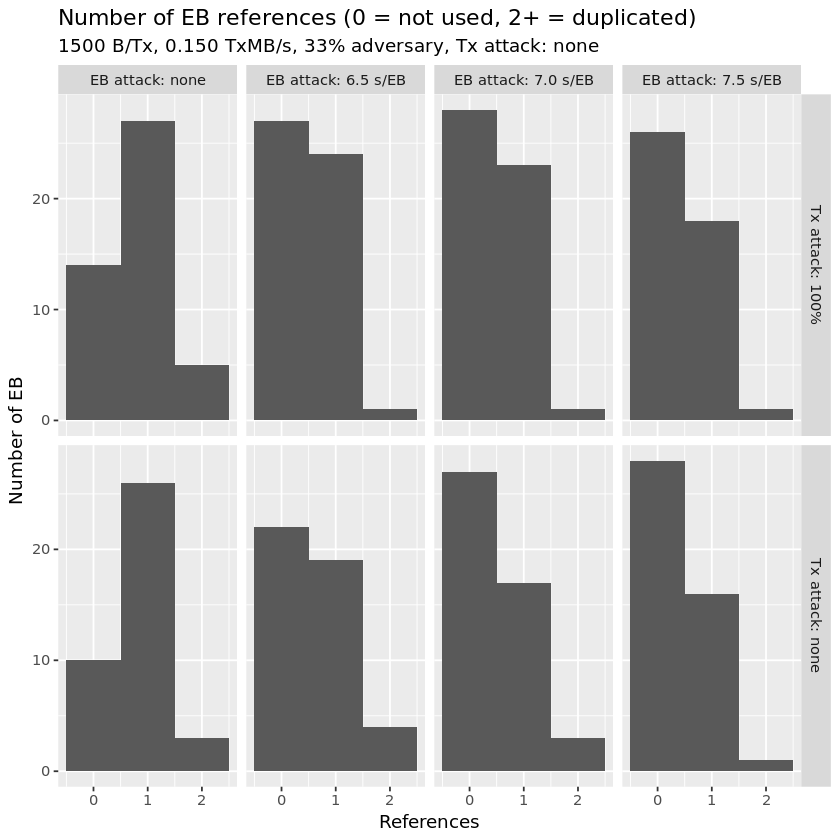

In [29]:
ggplot(
    lifecycle[
        `Message` == "EB",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
#   scale_x_sqrt() +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [30]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

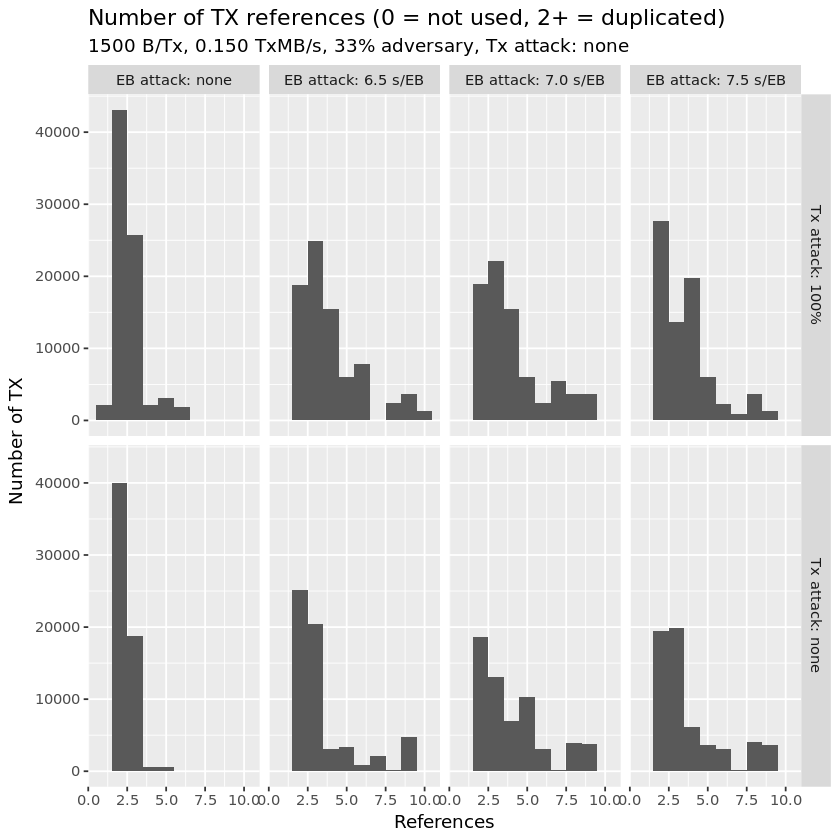

In [31]:
ggplot(
    lifecycle[
        `Message` == "TX",
        .(`References`),
        .(`VariedX`, `VariedY`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [32]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [33]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [34]:
outcomes <- lifecycle[
    `Message` == "TX" & `Created [s]` < txLast,
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    .(`VariedX`, `VariedY`)
]

In [35]:
totals <- 
    outcomes[
        , 
        .(
            `Total`=.N, 
            `Lost`=sum(is.na(`Time to reach ledger [s]`)),
            `1st min`=sum(`Time to reach ledger [s]`<=60,na.rm=TRUE),
            `2nd min`=sum(`Time to reach ledger [s]`>60&`Time to reach ledger [s]`<=120,na.rm=TRUE),
            `3rd min`=sum(`Time to reach ledger [s]`>120&`Time to reach ledger [s]`<=180,na.rm=TRUE)
        ), 
        .(`VariedX`, `VariedY`, `Submitted [minute]`)
    ]

#### Transactions reaching the ledger

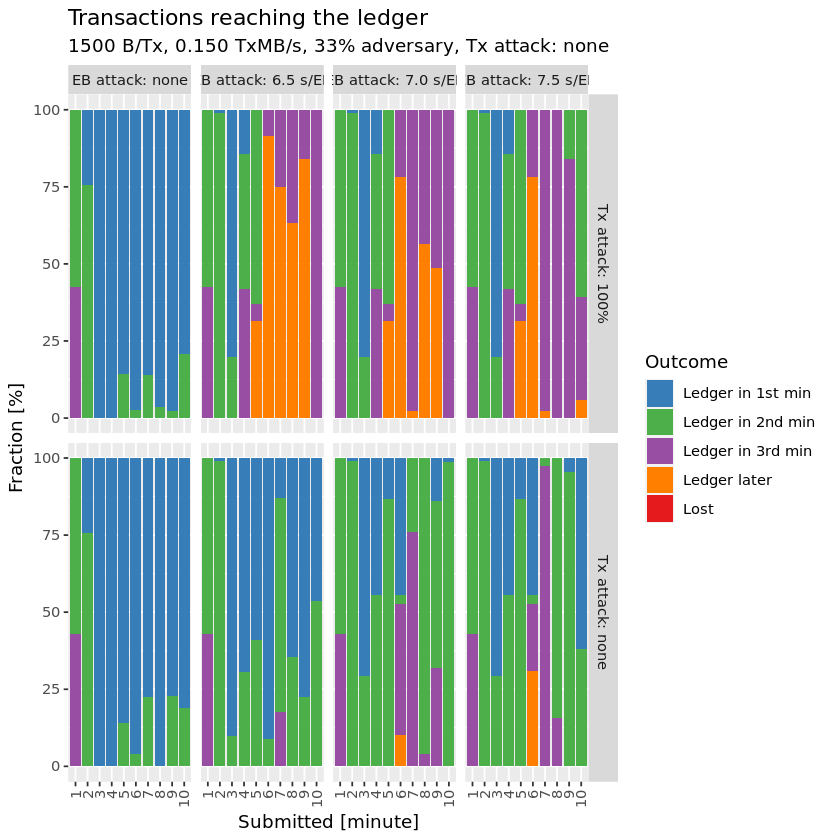

In [36]:
ggplot(
        melt(
            totals[
                , 
                .(
                    `Ledger in 1st min`=`1st min`/`Total`, 
                    `Ledger in 2nd min`=`2nd min`/`Total`, 
                    `Ledger in 3rd min`=`3rd min`/`Total`, 
                    `Ledger later`=(`Total`-`Lost`-`1st min`-`2nd min`-`3rd min`)/`Total`,
                    `Lost`=`Lost`/`Total`
                ), 
                .(`VariedX`, `VariedY`, `Submitted [minute]`)
            ],
            id.vars=c("VariedX", "VariedY", "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[, .(
            `VariedX`, `VariedY`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Ledger in 1st min", "Ledger in 2nd min", "Ledger in 3rd min", "Ledger later","Lost")), 
            `Fraction [%]`=100*`Fraction`
        )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_varied() +
    scale_fill_manual(values=c(
        "Ledger in 1st min"=brewer.pal(n=5, name="Set1")[[2]], 
        "Ledger in 2nd min"=brewer.pal(n=5, name="Set1")[[3]], 
        "Ledger in 3rd min"=brewer.pal(n=5, name="Set1")[[4]], 
        "Ledger later"=brewer.pal(n=5, name="Set1")[[5]],
        "Lost"=brewer.pal(n=5, name="Set1")[[1]]
    )) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [37]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [38]:
rm(lifecycle, outcomes, totals)

In [39]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,986845,52.8,1836050,98.1,1836050,98.1
Vcells,1816425,13.9,17465125,133.3,21831406,166.6


### Resource usage

In [40]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources %>% summary
resources[, `:=`(
    `VariedX`=factor(`Tx attack`),
    `VariedY`=ebFactor(`EB delay`)
)]

Loaded Rdata file: sampleSize = 1 


         Adversary                   EB delay              Tx attack   
 33% adversary:6000   EB attack: 6.5 s/EB:1500   Tx attack: 100%:3000  
                      EB attack: 7.0 s/EB:1500   Tx attack: none:3000  
                      EB attack: 7.5 s/EB:1500                         
                      EB attack: none    :1500                         
                                                                       
                                                                       
                                                                       
      Tx size            Throughput    Tx start [s]  Tx stop [s]   Sim stop [s]
 1500 B/Tx:6000   0.150 TxMB/s:6000   Min.   :60    Min.   :660   Min.   :900  
                                      1st Qu.:60    1st Qu.:660   1st Qu.:900  
                                      Median :60    Median :660   Median :900  
                                      Mean   :60    Mean   :660   Mean   :900  
                        

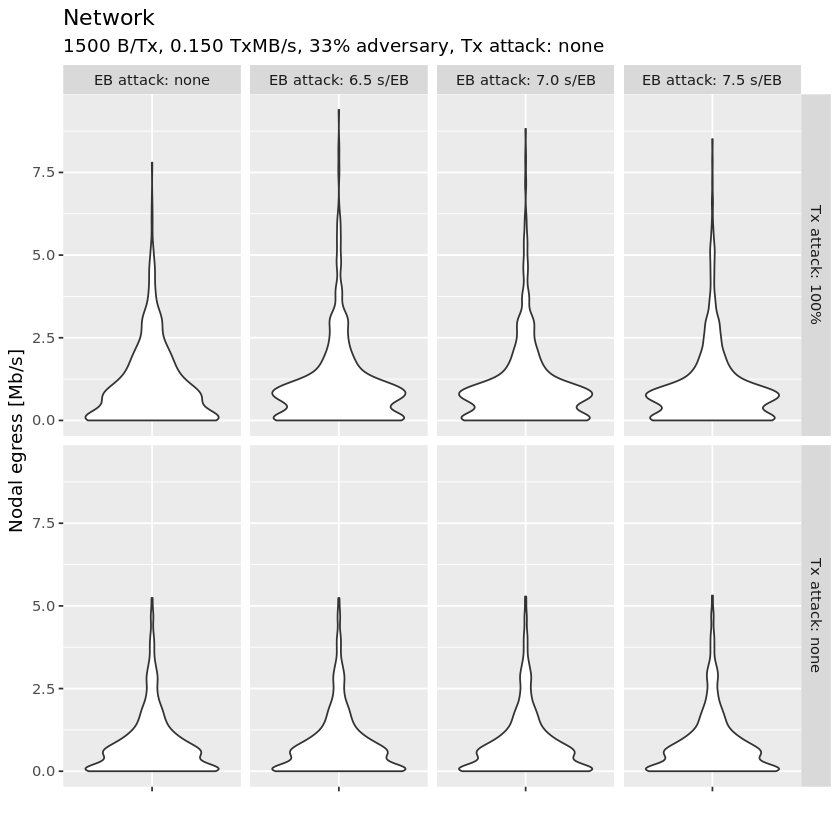

In [41]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_varied(wide=FALSE) +
    xlab("") +
    ggtitle("Network", label)

In [42]:
ggsave("plots/network.png", units="in", dpi=150, width=16, height=8)

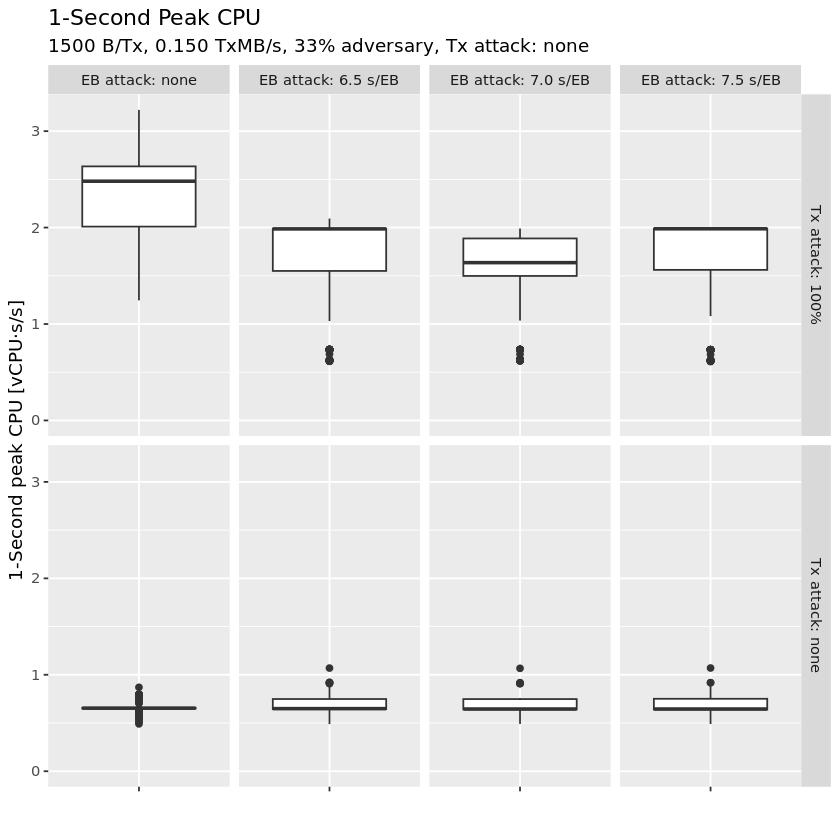

In [43]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=FALSE) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [44]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=16, height=8)

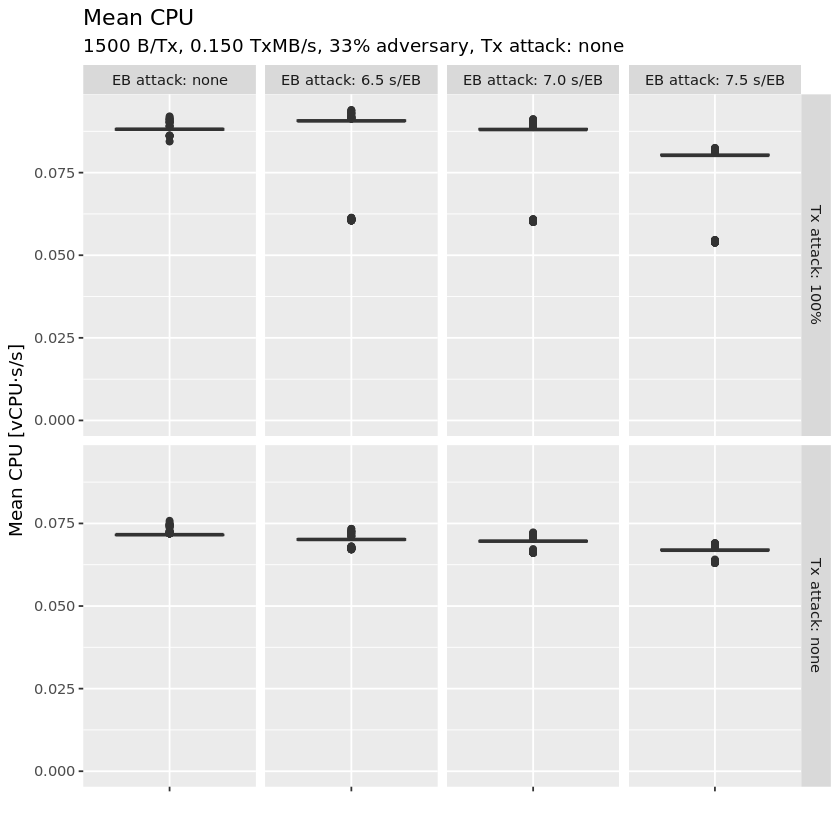

In [45]:
ggplot(
        resources[, .(`VariedX`, `VariedY`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
    aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=FALSE) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [46]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [47]:
rm(resources)

In [48]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1016615,54.3,1836050,98.1,1836050,98.1
Vcells,1870507,14.3,13972100,106.6,21831406,166.6


### Receipt of messages

#### Read results

In [49]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/receipts.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(receipts, old="Kind", new="Message")
receipts %>% summary
receipts[, `:=`(
    `VariedX`=factor(`Tx attack`),
    `VariedY`=ebFactor(`EB delay`)
)]

Loaded Rdata file: sampleSize = 0.15 


         Adversary                       EB delay       
 33% adversary:67072119   EB attack: 6.5 s/EB:17095511  
                          EB attack: 7.0 s/EB:16755853  
                          EB attack: 7.5 s/EB:16273565  
                          EB attack: none    :16947190  
                                                        
                                                        
                                                        
           Tx attack             Tx size                Throughput      
 Tx attack: 100%:37706910   1500 B/Tx:67072119   0.150 TxMB/s:67072119  
 Tx attack: none:29365209                                               
                                                                        
                                                                        
                                                                        
                                                                        
                                 

In [50]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [51]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[, .(`VariedX`, `VariedY`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_varied(scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

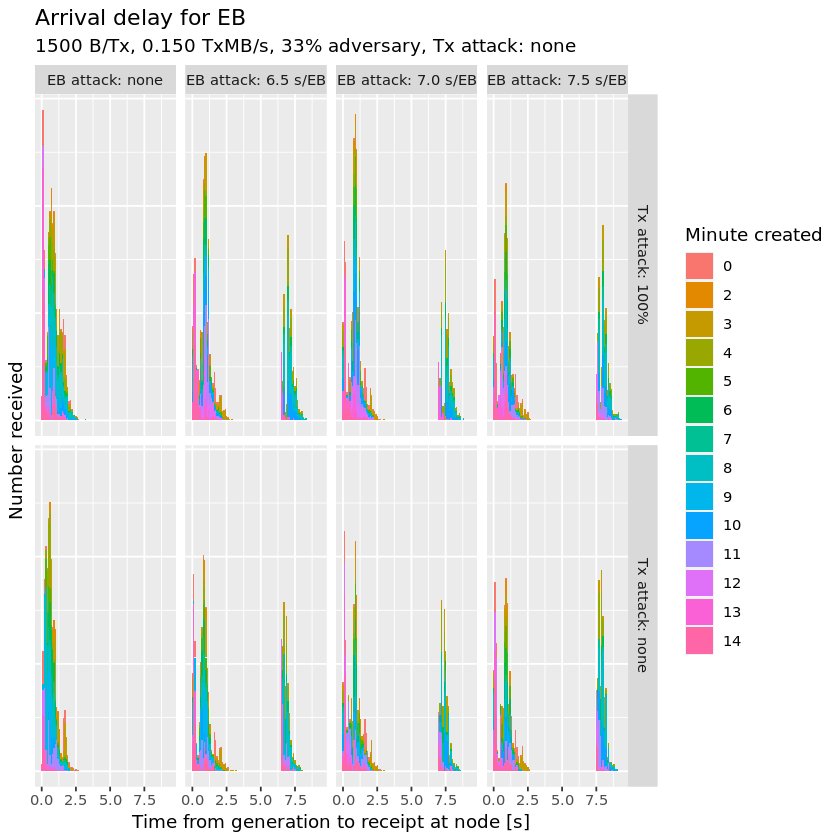

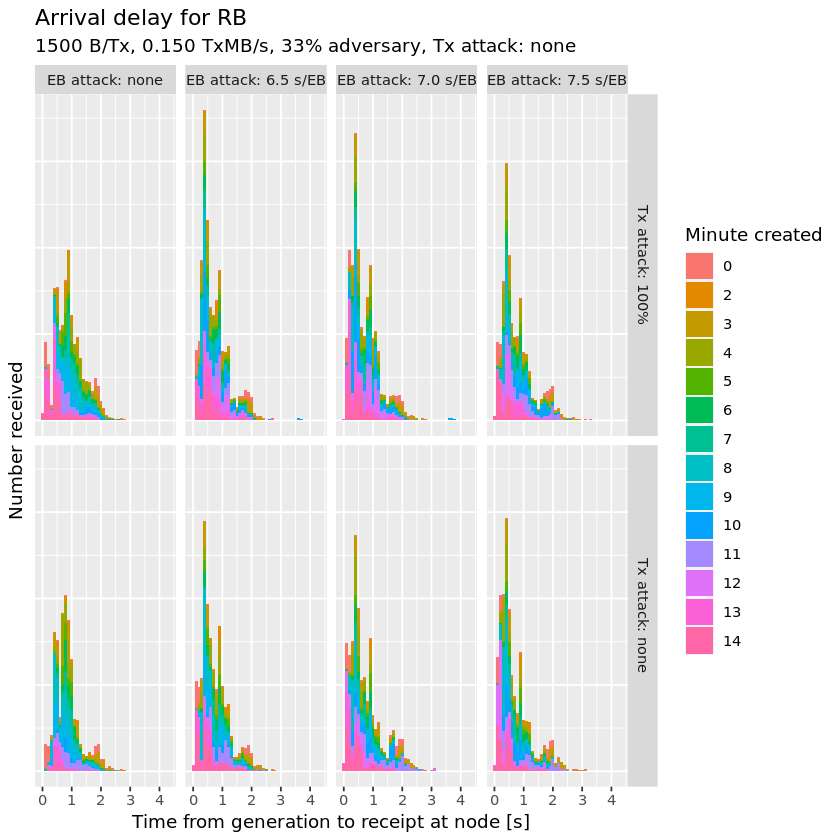

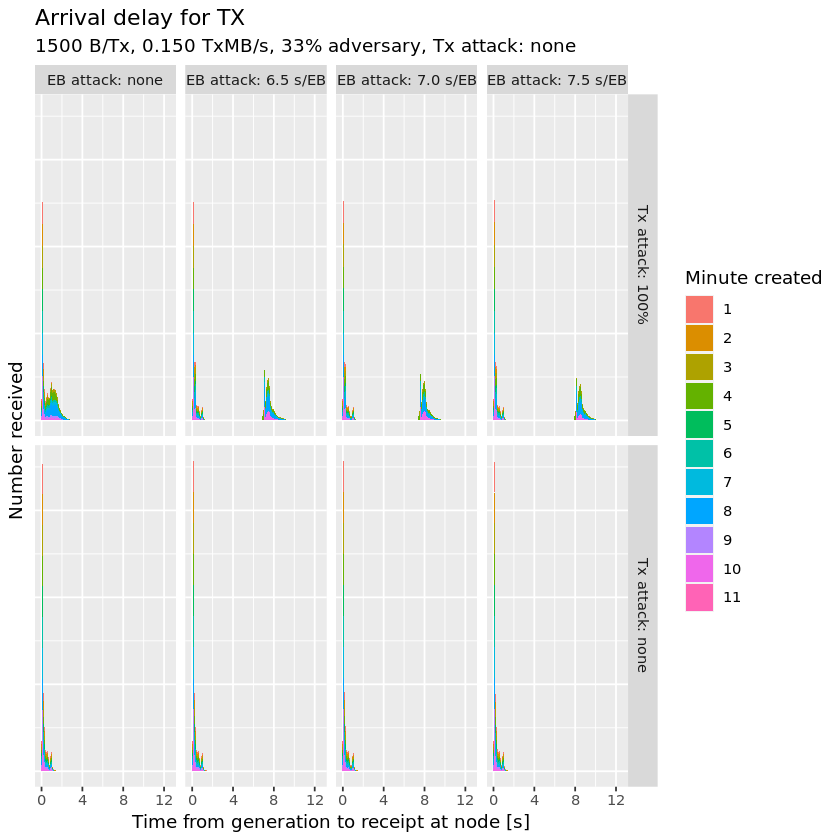

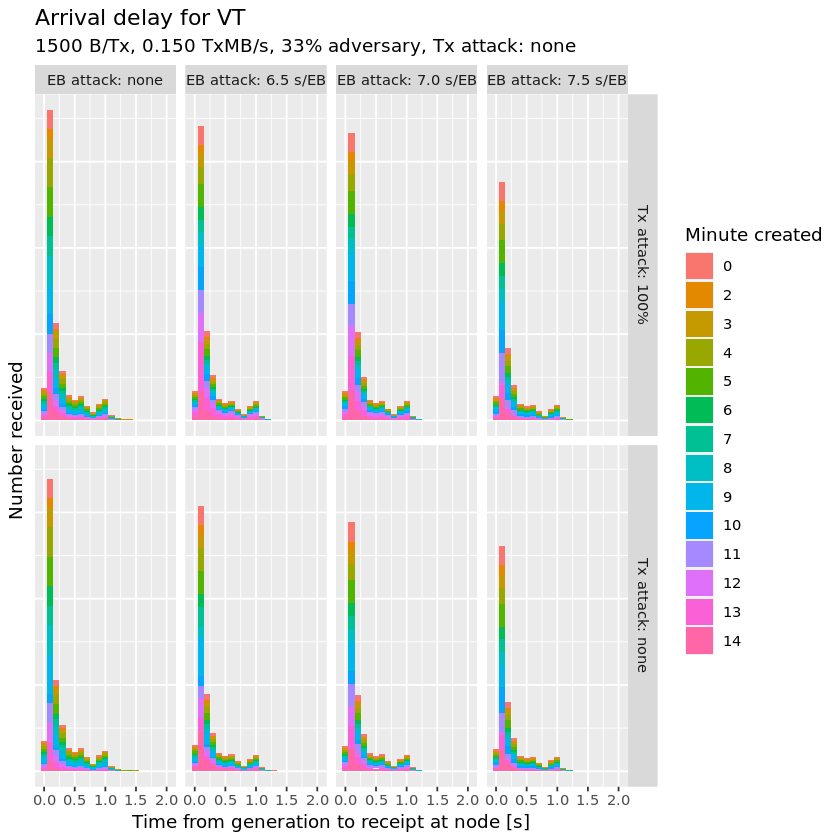

In [52]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Message` == k],
        paste("Arrival delay for", k),
        scales="fixed",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [53]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

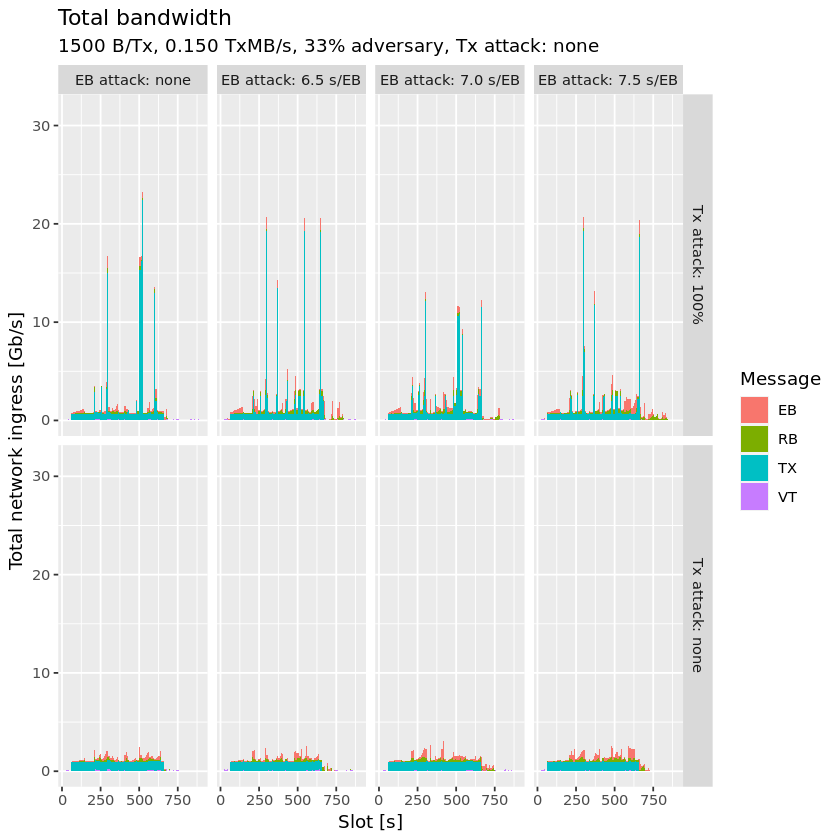

In [54]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="fixed",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [55]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [56]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/nodeCount/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

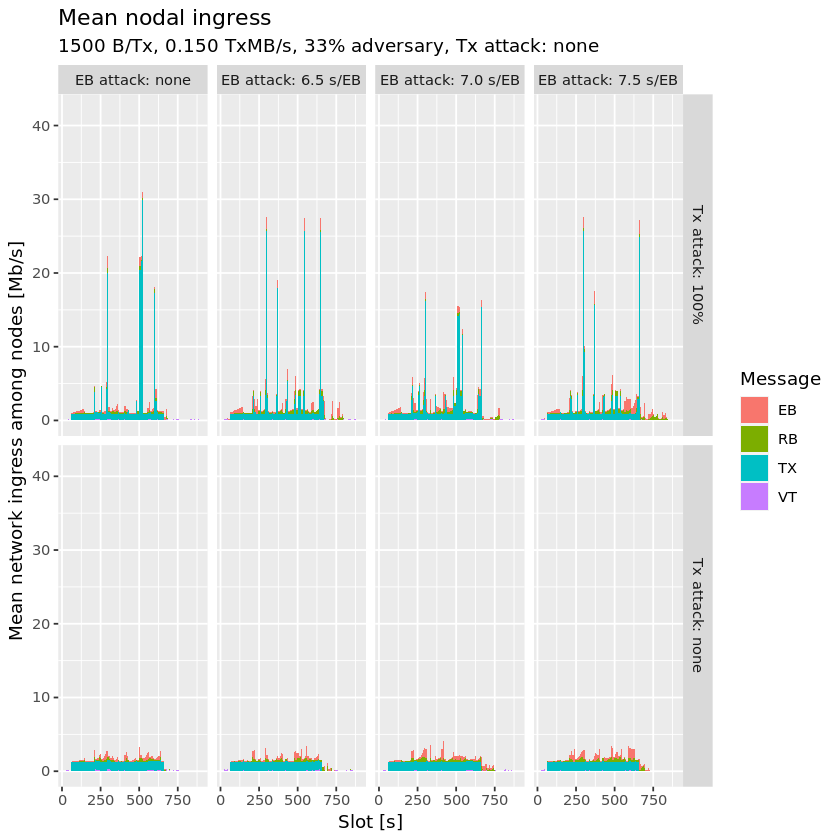

In [57]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="fixed",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [58]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`VariedX`, `VariedY`, `Slot`, `Message`)
            ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

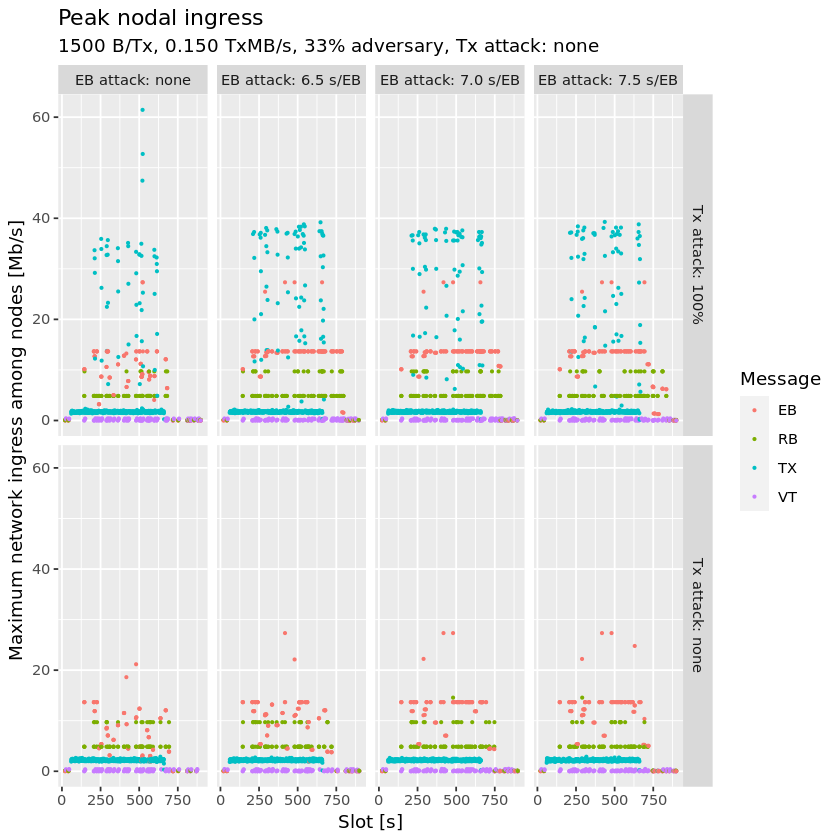

In [59]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [60]:
rm(receipts)

In [61]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1120980,59.9,2352535,125.7,2352535,125.7
Vcells,739902554,5645.1,1991408303,15193.3,3111575472,23739.5


### CPU usage

#### Read results

In [62]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/cpus.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
cpus %>% summary
cpus[, `:=`(
    `VariedX`=factor(`Tx attack`),
    `VariedY`=ebFactor(`EB delay`)
)]

Loaded Rdata file: sampleSize = 0.15 


         Adversary                       EB delay       
 33% adversary:66242412   EB attack: 6.5 s/EB:16788952  
                          EB attack: 7.0 s/EB:16473218  
                          EB attack: 7.5 s/EB:16012631  
                          EB attack: none    :16967611  
                                                        
                                                        
                                                        
           Tx attack             Tx size                Throughput      
 Tx attack: 100%:36836507   1500 B/Tx:66242412   0.150 TxMB/s:66242412  
 Tx attack: none:29405905                                               
                                                                        
                                                                        
                                                                        
                                                                        
                                 

In [63]:
cpusNode <-
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`VariedX`, `VariedY`, `Node`, `Slot`)
        ]

In [64]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [65]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_varied(scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

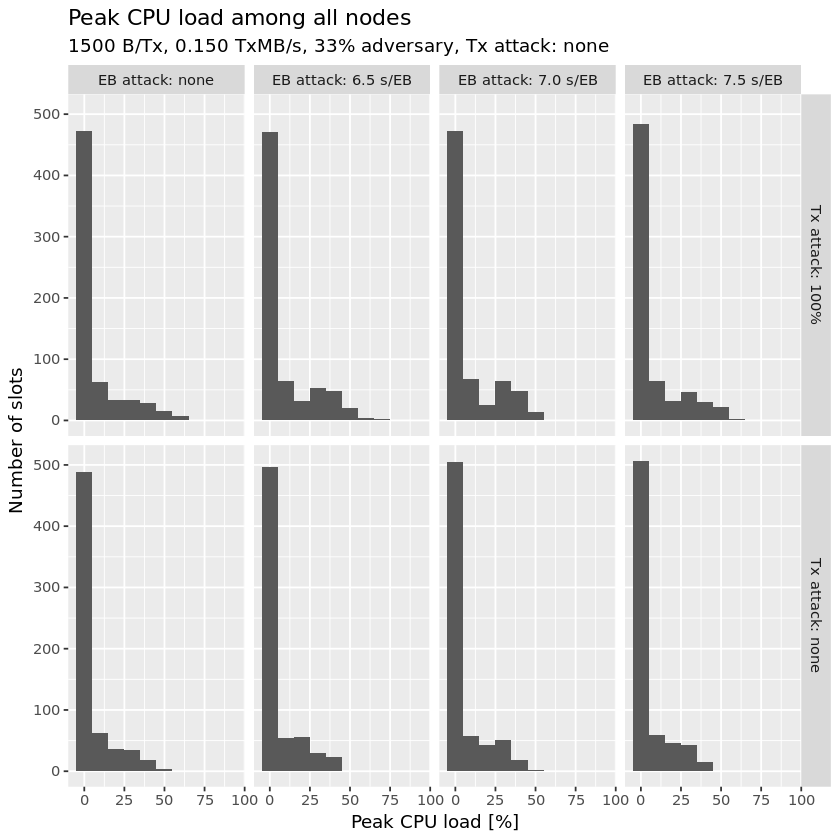

In [66]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="fixed",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [67]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_varied(scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

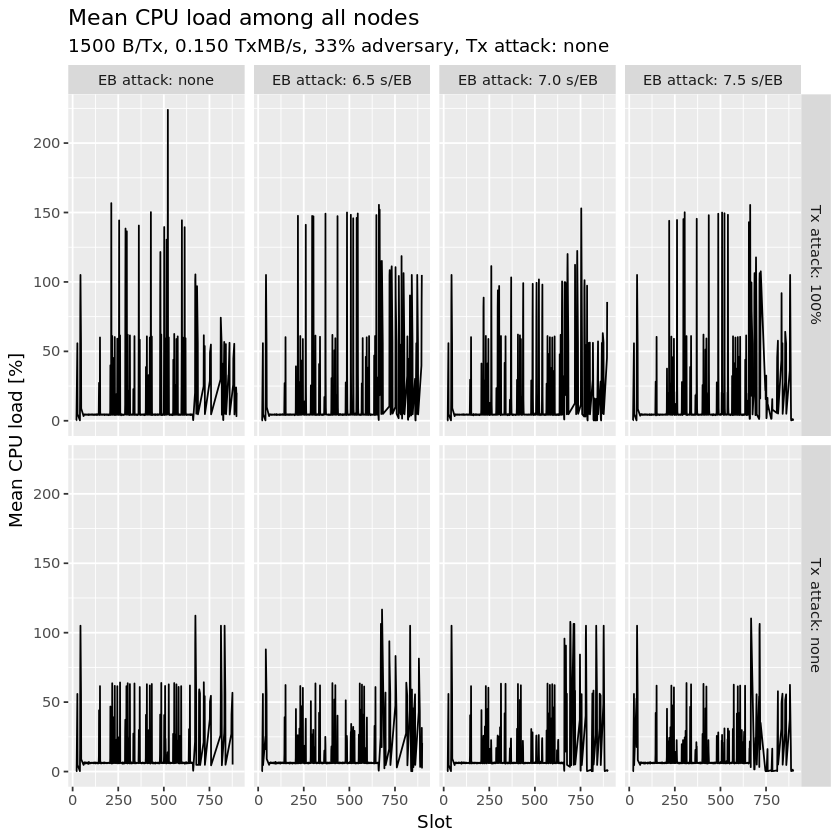

In [68]:
peakCpuTimeseries(
    cpusNode,
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [69]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount),
                by=.(`VariedX`, `VariedY`, `Task`)
            ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_varied(wide=FALSE, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

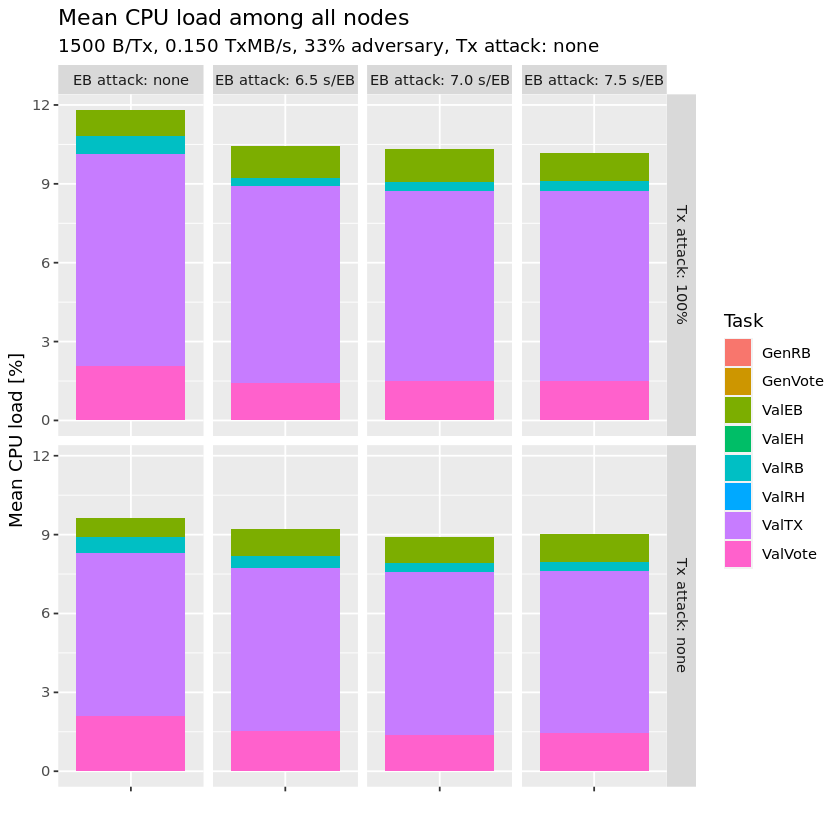

In [70]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="fixed",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [71]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/nodeCount/sampleSize),
                by=.(`VariedX`, `VariedY`, `Slot`, `Task`)
            ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_varied(scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

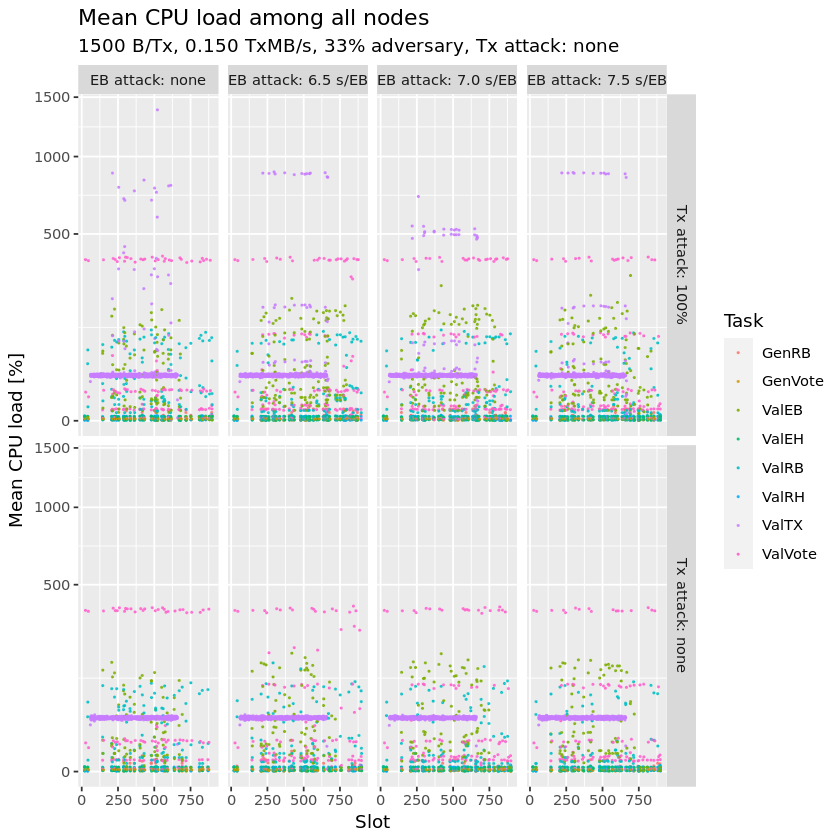

In [72]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [73]:
rm(cpus, cpusNode)

In [74]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1034271,55.3,2352535,125.7,2352535,125.7
Vcells,498739027,3805.1,1593126643,12154.6,3111575472,23739.5


### Block contents

### Read data

In [75]:
if (file.exists("results/sizes.Rdata")) {
    load(file="results/sizes.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    sizes <- fread("results/sizes.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(sizes, file="results/sizes.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(sizes, old="Kind", new="Message")
sizes %>% summary
sizes[, `:=`(
    `VariedX`=factor(`Tx attack`),
    `VariedY`=ebFactor(`EB delay`)
)]

Loaded Rdata file: sampleSize = 1 


         Adversary                  EB delay             Tx attack  
 33% adversary:742   EB attack: 6.5 s/EB:194   Tx attack: 100%:390  
                     EB attack: 7.0 s/EB:198   Tx attack: none:352  
                     EB attack: 7.5 s/EB:180                        
                     EB attack: none    :170                        
                                                                    
                                                                    
                                                                    
      Tx size           Throughput   Tx start [s]  Tx stop [s]   Sim stop [s]
 1500 B/Tx:742   0.150 TxMB/s:742   Min.   :60    Min.   :660   Min.   :900  
                                    1st Qu.:60    1st Qu.:660   1st Qu.:900  
                                    Median :60    Median :660   Median :900  
                                    Mean   :60    Mean   :660   Mean   :900  
                                    3rd Qu.:60    3rd Qu.:

In [76]:
txSize <- sizes[, as.numeric(sub(" .*$", "", unique(`Tx size`)))]
txSize

[1] 1500

### EB contents

#### Transactions

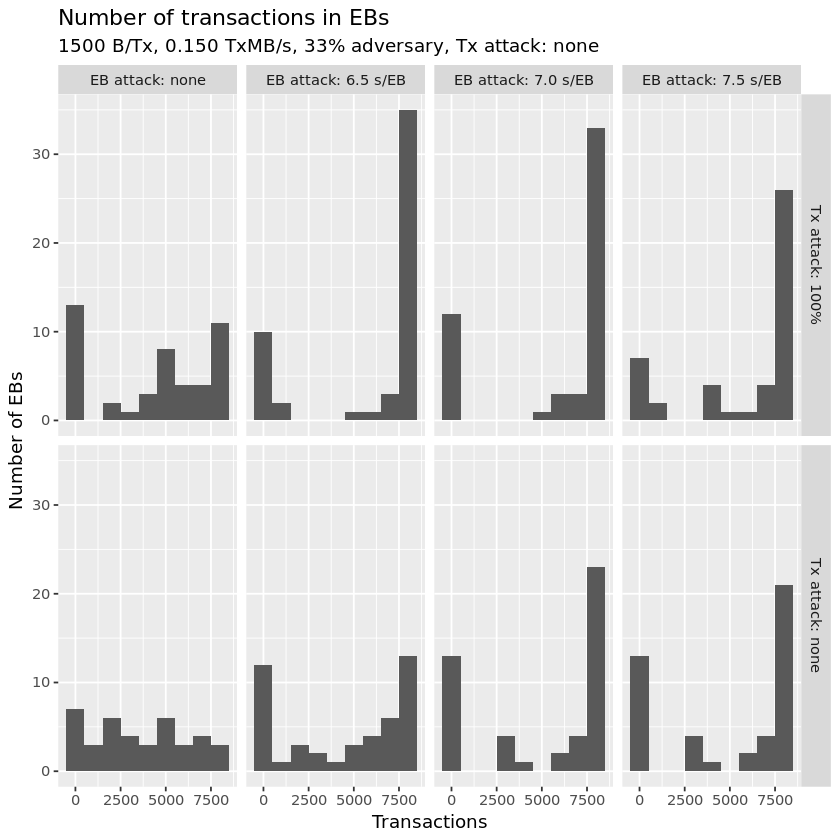

In [77]:
ggplot(sizes[`Message` == "EB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_varied() +
    ylab("Number of EBs") +
    ggtitle("Number of transactions in EBs", label)

In [78]:
ggsave("plots/contents-ebs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

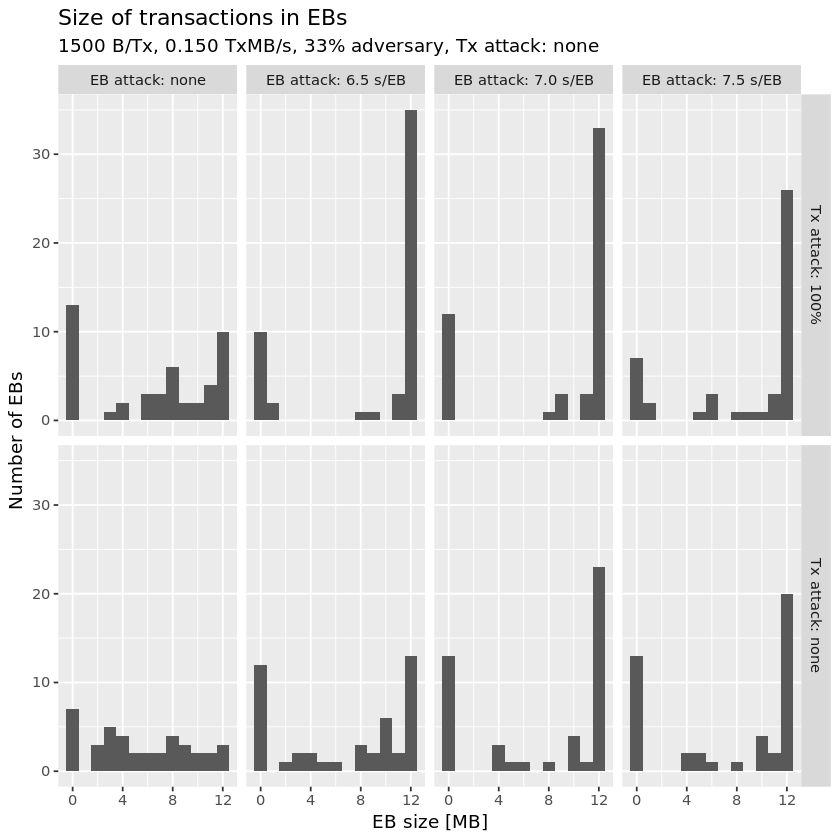

In [79]:
ggplot(
        sizes[`Message` == "EB", .(`EB size [MB]`=`Transactions`*txSize/1e6), .(`VariedX`, `VariedY`)], 
    aes(x=`EB size [MB]`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
    ylab("Number of EBs") +
    ggtitle("Size of transactions in EBs", label)

In [80]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=16, height=8)

### RB contents

#### Transactions

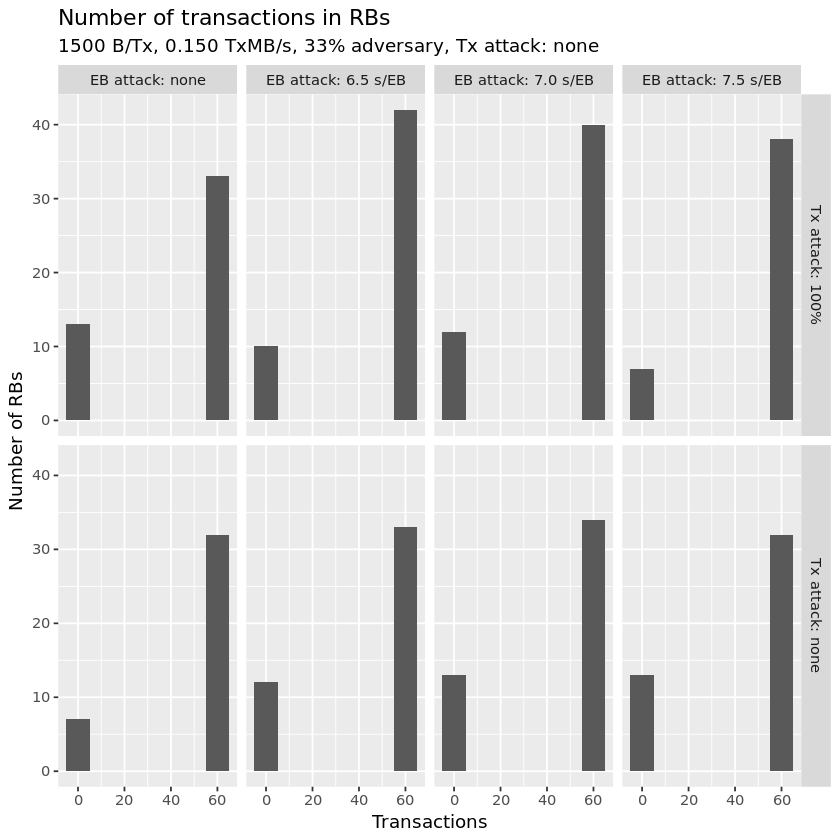

In [81]:
ggplot(sizes[`Message` == "RB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs") +
    ggtitle("Number of transactions in RBs", label)

In [82]:
ggsave("plots/contents-rbs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

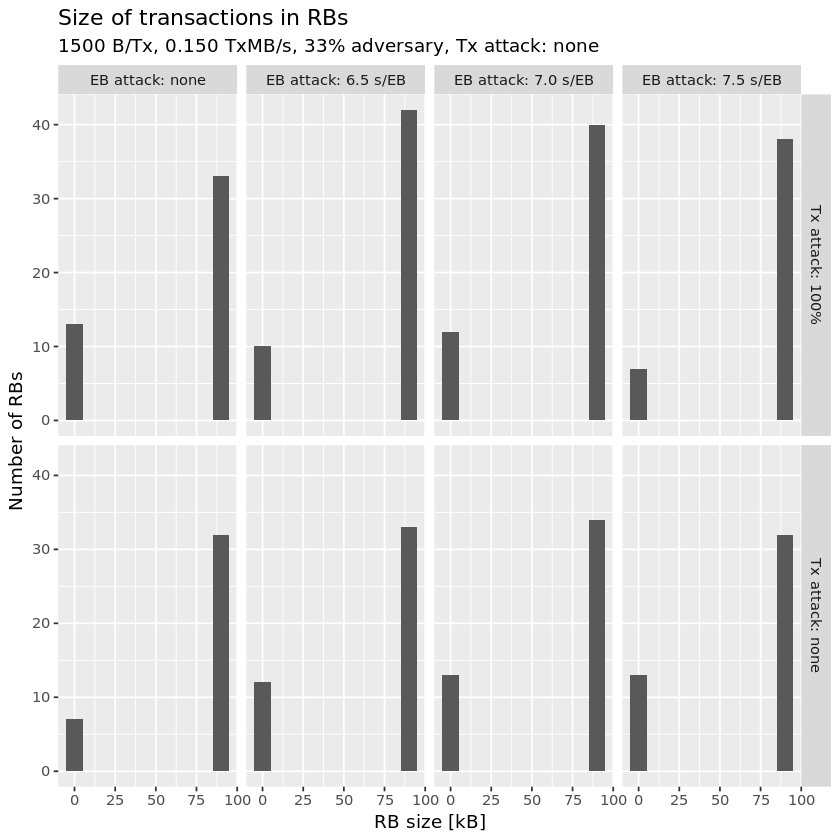

In [83]:
ggplot(
        sizes[`Message` == "RB", .(`RB size [kB]`=`Transactions`*txSize/1e3), .(`VariedX`, `VariedY`)],
    aes(x=`RB size [kB]`)
) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs") +
    ggtitle("Size of transactions in RBs", label)

In [84]:
ggsave("plots/contents-rbs-size.png", units="in", dpi=150, width=16, height=8)

### Disposition of blocks

#### Data processing

In [85]:
ebSizes <- 
        sizes[`Message` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`VariedX`, `VariedY`, `Item`=`Endorses`)][
        sizes[`Message` == "EB", .(`EB Transactions`=`Transactions`), .(`VariedX`, `VariedY`, `Item`)], 
            on=c("VariedX", "VariedY", "Item")
        ][
            ,
            .(
                `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
                `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
            ),
            .(`VariedX`, `VariedY`, `Item`)
        ]

In [86]:
rbSizes <- 
        ebSizes[
            ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`VariedX`, `VariedY`, `Endorses`=`Item`)][
                sizes[`Message` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`VariedX`, `VariedY`, `Item`, `Endorses`)],
                on=c("VariedX", "VariedY", "Endorses")
            ],
            on=c("VariedX", "VariedY", "Item")
        ][
            ,
            .(
                `Generated [s]`,
                `RB`=`RB Transactions`,
                `EB later not certified`=`EB txs later not certified`,
                `EB later certified`=`EB txs later certified`,
                `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
            ),
            , .(`VariedX`, `VariedY`, `Item`)
        ]

In [87]:
blocks <- melt(
    rbSizes, 
    id.vars=c("VariedX", "VariedY", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Sanity checks

In [88]:
ebSizes[, .N] == sizes[`Message` == "EB", .N]

[1] TRUE

In [89]:
ebSizes[, sum(`EB txs later not certified`) + sum(`EB txs later certified`)] == sizes[`Message` == "EB", sum(`Transactions`)]

[1] TRUE

In [90]:
rbSizes[, .N] == sizes[`Message` == "RB", .N]

[1] TRUE

In [91]:
rbSizes[, sum(`RB`)] == sizes[`Message` == "RB", sum(`Transactions`)]

[1] TRUE

In [92]:
rbSizes[, sum(`EB later not certified`) + sum(`EB later certified`)] == sizes[`Message` == "EB", sum(`Transactions`)]

[1] TRUE

In [93]:
# TODO: Compute precise equality that accounts for forks.
rbSizes[, sum(`EB later certified`)] <= rbSizes[, sum(`EB now certified`)]

[1] TRUE

#### Transactions

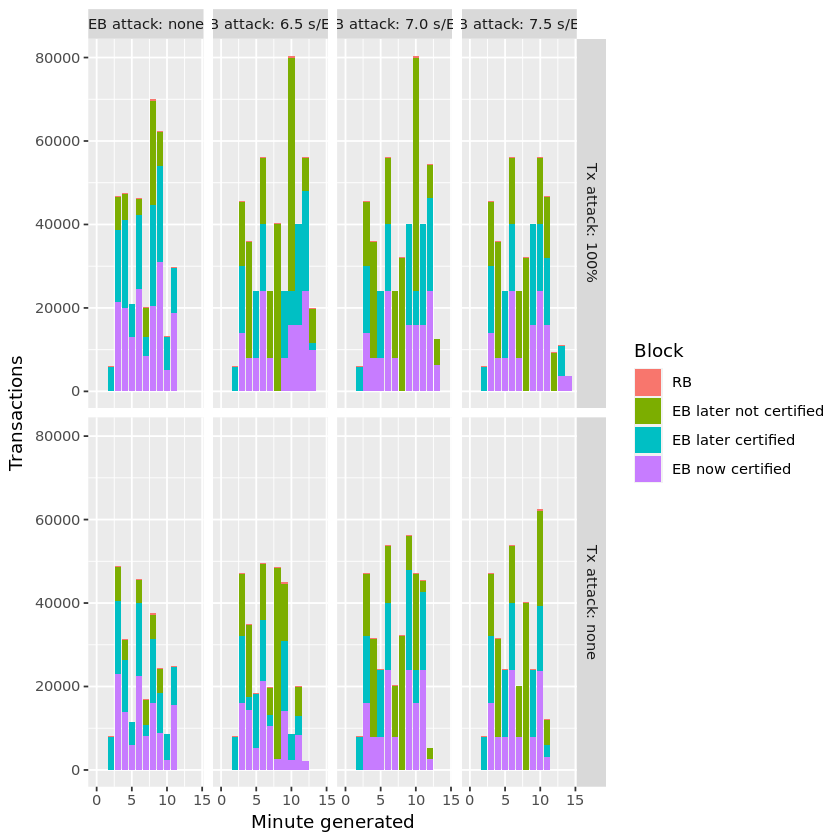

In [94]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))],
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied()

In [95]:
ggsave("plots/disposition-txs-timeseries.png", units="in", dpi=150, width=16, height=8)

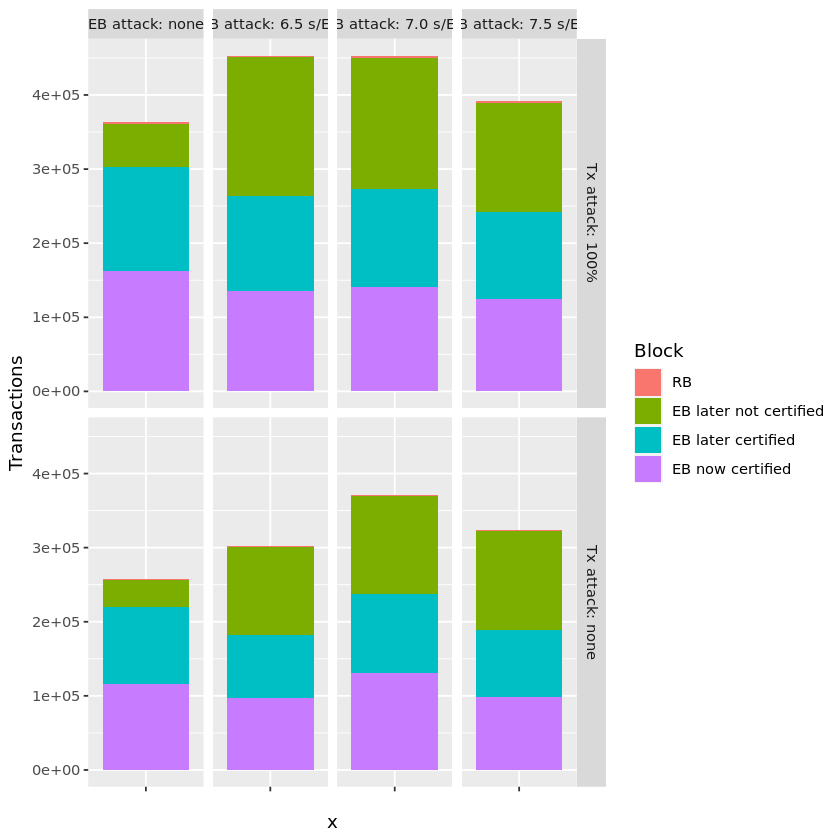

In [96]:
ggplot(
        blocks[, .(`Transactions`=sum(`Transactions`)), .(`VariedX`, `VariedY`, `Block`)],
    aes(x="", y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied()

In [97]:
ggsave("plots/disposition-txs-histogram.png", units="in", dpi=150, width=16, height=8)

#### Sizes

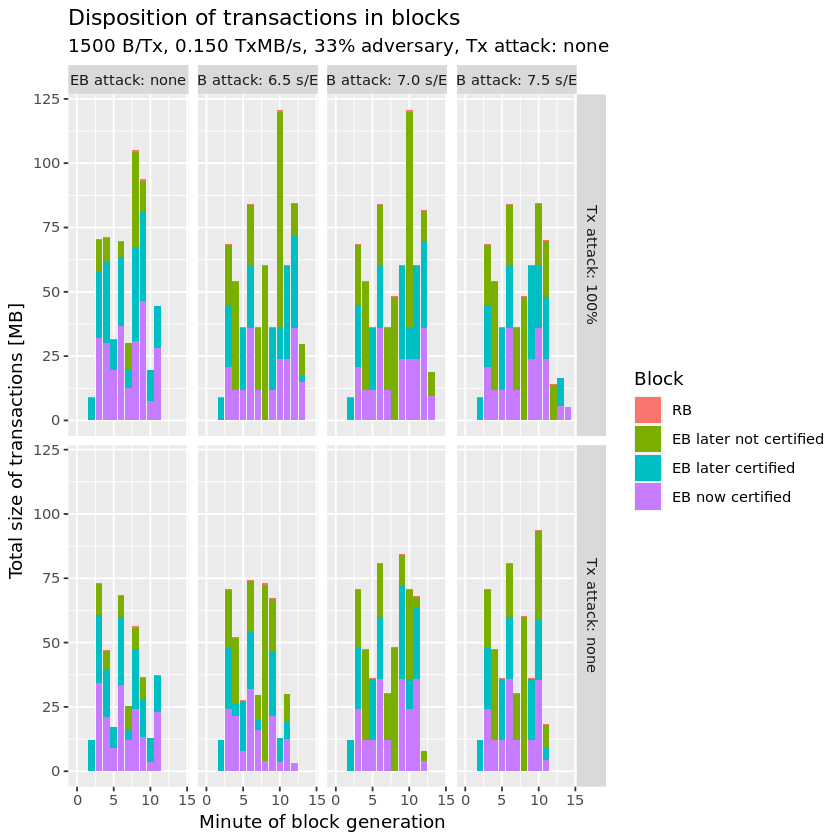

In [98]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied() +
    ggtitle("Disposition of transactions in blocks", label)

In [99]:
ggsave("plots/disposition-size-timeseries.png", units="in", dpi=150, width=16, height=8)

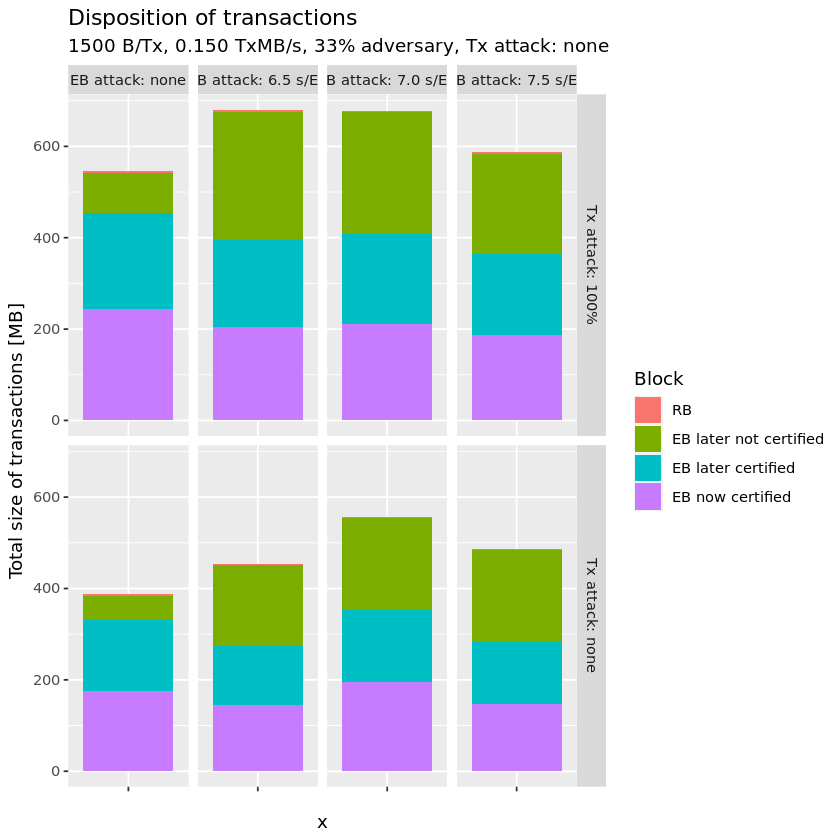

In [100]:
ggplot(
        blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*txSize/1e6), .(`VariedX`, `VariedY`, `Block`)], 
    aes(x="", y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_varied() +
    ggtitle("Disposition of transactions", label)

In [101]:
ggsave("plots/disposition-size-histogram.png", units="in", dpi=150, width=16, height=8)